/tmp/ipykernel_2244/4157068788.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Thr"] = df2["Completeness"].apply(assign_threshold)
/tmp/ipykernel_2244/4157068788.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Thr"] = df2["Completeness"].apply(assign_threshold)
/tmp/ipykernel_2244/4157068788.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

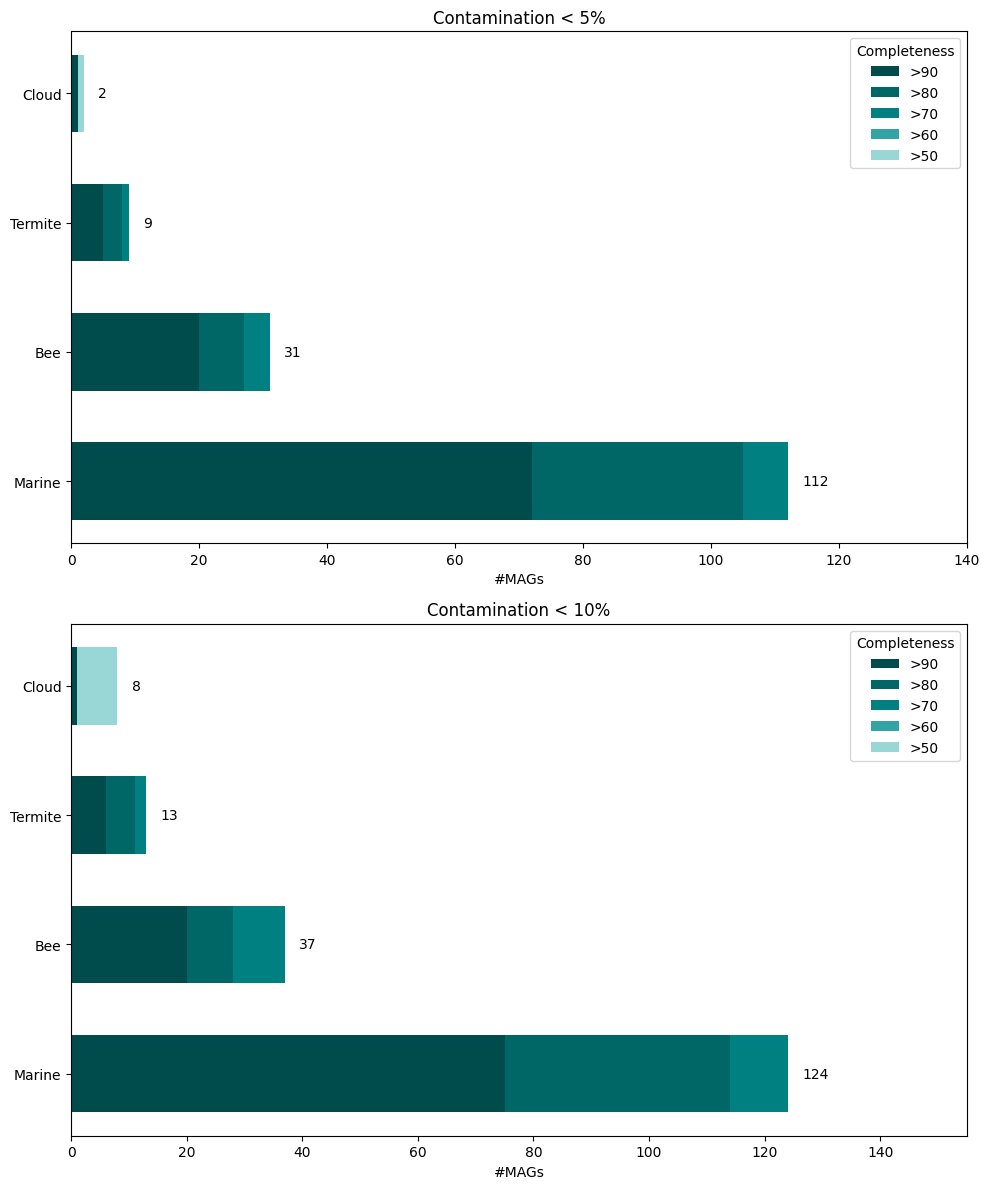

Bee: drep found 161 MAGs
Cloud: drep found 230 MAGs
Termite: drep found 24 MAGs
Marine: drep found 153 MAGs


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

files = {
    "Bee": "../bee/checkm2.tsv",
    "Cloud": "../cloud/checkm2.tsv",
    "Termite": "../termite/checkm2.tsv",
    "Marine": "../marine/checkm2.tsv",
}

drep_files = { 
    "Bee": "../bee/drep.csv",
    "Cloud": "../cloud/drep.csv",
    "Termite": "../termite/drep.csv",
    "Marine": "../marine/drep.csv",
}

thresholds = [">90", ">80", ">70", ">60", ">50"]
colors = ["#004c4c", "#006666", "#008080", "#33a3a3", "#99d6d6"]

def count_drep_bins(filename):
    count = 0
    with open(filename, "r") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if i == 0:
                continue
            if line == "":
                continue
            count += 1
    return count

def assign_threshold(comp):
    if comp >= 90:
        return ">90"
    elif comp >= 80:
        return ">80"
    elif comp >= 70:
        return ">70"
    elif comp >= 60:
        return ">60"
    elif comp >= 50:
        return ">50"
    return None

def load_counts(cont_cutoff):
    result = {thr: [] for thr in thresholds}
    totals = []

    for usecase, f in files.items():
        df = pd.read_csv(f, sep="\t")

        df2 = df[df["Contamination"] < cont_cutoff]
        df2["Thr"] = df2["Completeness"].apply(assign_threshold)

        counts = df2["Thr"].value_counts()

        per_thr = []
        total = 0
        for thr in thresholds:
            val = counts.get(thr, 0)
            per_thr.append(val)
            total += val

        for thr, val in zip(thresholds, per_thr):
            result[thr].append(val)

        totals.append(total)

    usecases = list(files.keys())
    sorting_idx = np.argsort(totals)
    sorting_idx = sorting_idx[::-1]

    sorted_use_cases = [usecases[i] for i in sorting_idx]

    sorted_result = {
        thr: [result[thr][i] for i in sorting_idx]
        for thr in thresholds
    }

    return sorted_use_cases, sorted_result

drep_counts = {tool: count_drep_bins(f) for tool, f in drep_files.items()}

def plot_stacked(ax, tools, data, title):
    y = np.arange(len(tools))
    left = np.zeros(len(tools))

    for i, thr in enumerate(thresholds):
        values = data[thr]
        ax.barh(y, values, left=left, color=colors[i], label=thr, height=0.6)
        left += np.array(values)

    for i, tool in enumerate(tools):
        ax.text(
            left[i] + (max(left) * 0.02),
            i,
            str(int(left[i])),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.set_xlim(0, max(left) * 1.25)

    ax.set_yticks(y)
    ax.set_yticklabels(tools)
    ax.set_xlabel("#MAGs")
    ax.set_title(title)

use_cases, data5 = load_counts(cont_cutoff=5)
_, data10 = load_counts(cont_cutoff=10)

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=False)

plot_stacked(axs[0], use_cases, data5, "Contamination < 5%")
plot_stacked(axs[1], use_cases, data10, "Contamination < 10%")

axs[0].legend(title="Completeness", loc="upper right")
axs[1].legend(title="Completeness", loc="upper right")

plt.tight_layout()

# Save PNG
plt.savefig("combined_bar_plot.png", dpi=300)

plt.show()

for uc in drep_files:
    print(f'{uc}: drep found {count_drep_bins(drep_files[uc])} MAGs')
